<a href="https://colab.research.google.com/github/omarjilanijidan/Iris-Cataract-Detection-From-Fundus-Images/blob/main/ResNet50_with_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# New Section

In [ ]:
# Import necessary libraries
import os
import numpy as np
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Model

In [ ]:
# Authenticate and mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
image_size = 224

In [ ]:
# Define file paths for saved data
load_path = '/content/drive/MyDrive/Papers/Dataset Fundus Image/augmented-data'
train_images_path = os.path.join(load_path, 'X_train.npy')
train_labels_path = os.path.join(load_path, 'y_train.npy')
test_images_path = os.path.join(load_path, 'X_test.npy')
test_labels_path = os.path.join(load_path, 'y_test.npy')

# Load training and testing data from saved files
X_train = np.load(train_images_path)
y_train = np.load(train_labels_path)
X_test = np.load(test_images_path)
y_test = np.load(test_labels_path)

In [ ]:
# Print number of images used for training and testing
print(f"Number of images used for training: {len(X_train)}")
print(f"Number of images used for testing: {len(X_test)}")

Number of images used for training: 3997
Number of images used for testing: 1004


In [ ]:
# Load RESNet50 model and remove final layer
resnet50 = ResNet50(weights="imagenet", include_top=False, input_shape=(image_size, image_size, 3))
for layer in resnet50.layers:
    layer.trainable = False

In [ ]:

from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization

x = resnet50.output
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(49, activation="sigmoid")(x)
x = GlobalAveragePooling2D()(x)
output = Dense(1, activation="sigmoid")(x)
model = Model(inputs=resnet50.input, outputs=output)

# Compile model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
# Fit model on train data
history = model.fit(X_train, y_train, epochs=15, batch_size=49, validation_data=(X_test, y_test))

Epoch 1/15
82/82 [==============================] - 539s 7s/step - loss: 0.5674 - accuracy: 0.7148 - val_loss: 0.7282 - val_accuracy: 0.5010
Epoch 2/15
82/82 [==============================] - 575s 7s/step - loss: 0.4852 - accuracy: 0.7751 - val_loss: 0.6581 - val_accuracy: 0.5598
Epoch 3/15
82/82 [==============================] - 543s 7s/step - loss: 0.4505 - accuracy: 0.7931 - val_loss: 0.5005 - val_accuracy: 0.7510
Epoch 4/15
82/82 [==============================] - 580s 7s/step - loss: 0.4221 - accuracy: 0.8094 - val_loss: 0.4544 - val_accuracy: 0.7878
Epoch 5/15
82/82 [==============================] - 580s 7s/step - loss: 0.4127 - accuracy: 0.8246 - val_loss: 0.4204 - val_accuracy: 0.7988
Epoch 6/15
82/82 [==============================] - 524s 6s/step - loss: 0.4046 - accuracy: 0.8221 - val_loss: 0.4250 - val_accuracy: 0.7689
Epoch 7/15
82/82 [==============================] - 566s 7s/step - loss: 0.3964 - accuracy: 0.8259 - val_loss: 0.4074 - val_accuracy: 0.8327
Epoch 8/15
82

In [ ]:
# Print maximum training accuracy
max_train_acc = max(history.history["accuracy"])
print(f"Maximum training accuracy: {max_train_acc:.4f}")

# Print maximum validation accuracy
max_val_acc = max(history.history["val_accuracy"])
print(f"Maximum validation accuracy: {max_val_acc:.4f}")

# Print minimum training loss
min_train_loss = min(history.history["loss"])
print(f"Minimum training loss: {min_train_loss:.4f}")

# Print minimum validation loss
min_val_loss = min(history.history["val_loss"])
print(f"Minimum validation loss: {min_val_loss:.4f}")

Maximum training accuracy: 0.8541
Maximum validation accuracy: 0.8865
Minimum training loss: 0.3527
Minimum validation loss: 0.2844


Text(0.5, 0, 'Epoch')

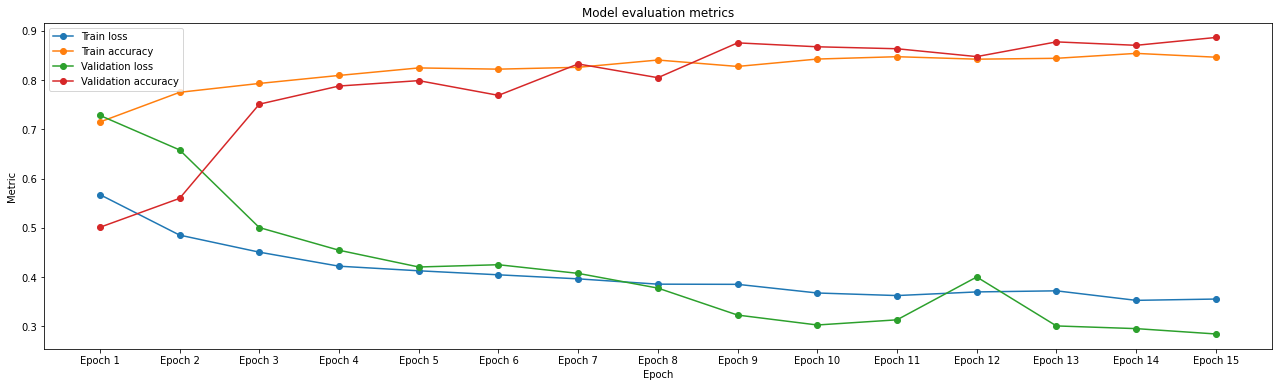

In [ ]:
# Extract metric histories
loss = history.history['loss']
acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

# Create plot
fig, ax = plt.subplots(figsize=(22, 6))

# Get epoch names
epoch_names = ['Epoch {}'.format(i) for i in range(1, len(loss) + 1)]

# Plot loss, accuracy, validation loss, and validation accuracy as a combination of lines and dots over epochs
ax.plot(epoch_names, loss, '-o', label='Train loss')
ax.plot(epoch_names, acc, '-o', label='Train accuracy')
ax.plot(epoch_names, val_loss, '-o', label='Validation loss')
ax.plot(epoch_names, val_acc, '-o', label='Validation accuracy')

# Add legend and labels
ax.legend(loc='upper left')
ax.set_title('Model evaluation metrics')
ax.set_ylabel('Metric')
ax.set_xlabel('Epoch')

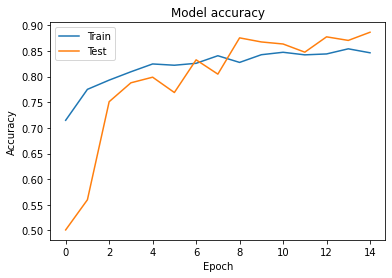

In [ ]:
# Plot accuracy and loss during training
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc="upper left")
plt.show()

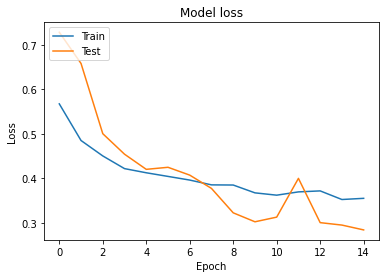

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc="upper left")
plt.show()

2/2 [==============================] - 6s 2s/step


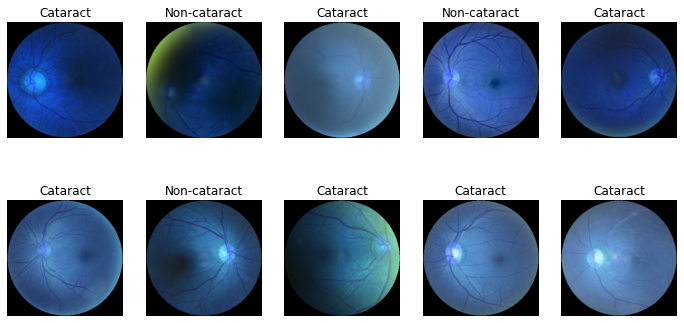

In [ ]:
test_dir = "/content/drive/MyDrive/Papers/Extra/preprocessed_images"

# Load test images
test_images = []
for img in os.listdir(test_dir)[:50]:
    image_path = os.path.join(test_dir, img)
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (image_size, image_size))
    image = image / 255.0
    test_images.append(image)

# Convert test images to numpy array
test_images = np.array(test_images)

# Use model to predict labels for test images
predictions = model.predict(test_images)

# Create labels for test images
labels = ["Cataract" if prediction >= 0.5 else "Non-cataract" for prediction in predictions]

# Create subplots with 2 rows and 5 columns
fig, axs = plt.subplots(2, 5, figsize=(12, 6))

# Plot test images in subplots
for ax, img, label in zip(axs.flatten(), test_images, labels):
    ax.imshow(img)
    ax.axis("off")
    ax.set(title=label)

plt.show()

In [ ]:
# Get model evaluation on test data
evaluation = model.evaluate(X_test, y_test, verbose=0)

# Print model evaluation
print(f"Test loss: {evaluation[0]}")
print(f"Test accuracy: {evaluation[1]}")

Test loss: 0.2844250202178955
Test accuracy: 0.886454164981842


In [ ]:
from sklearn.metrics import confusion_matrix
# Make predictions on the test data
y_pred = model.predict(X_test)

# Threshold predictions to create a binary classification
y_pred = (y_pred > 0.5).astype(int)

# Get the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Calculate specificity
specificity = cm[0][0] / (cm[0][0] + cm[0][1])
print("Specificity:", specificity)

32/32 [==============================] - 100s 3s/step
Specificity: 0.8383233532934131


In [ ]:
# Calculate sensitivity
sensitivity = cm[1][1] / (cm[1][0] + cm[1][1])
print("Sensitivity:", sensitivity)

Sensitivity: 0.9343936381709742


In [ ]:
from sklearn.metrics import classification_report
# Print classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.84      0.88       501
           1       0.85      0.93      0.89       503

    accuracy                           0.89      1004
   macro avg       0.89      0.89      0.89      1004
weighted avg       0.89      0.89      0.89      1004



In [ ]:
# Install latest version of mlxtend library
!pip install -U mlxtend

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


(<Figure size 576x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f0ed1bf6a90>)

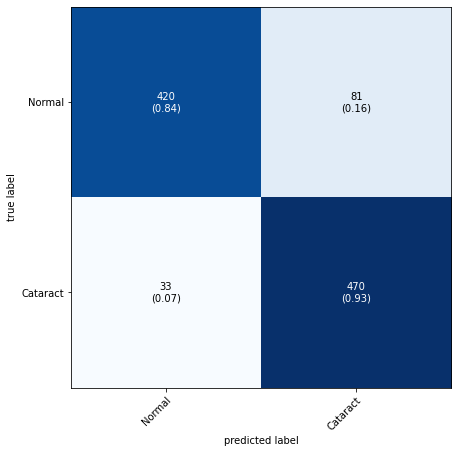

In [ ]:
# Import plot_confusion_matrix function
from mlxtend.plotting import plot_confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plot_confusion_matrix(conf_mat=cm, figsize=(8,7), class_names=["Normal", "Cataract"], show_normed=True)